In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model
import networkx as nx
from flow_computation import flow_computation
import time
from generate_network import generate_network

In [2]:
## Load necessary data
G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))
paths = pickle.load(open('data/final_paths.p', "rb"))

In [31]:
G, paths, inserted = generate_network(G, paths, 25)

There were 25 nodes added, the longest remaining link is now: 35117.6542642193


In [32]:
pos_dict = {}

for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

harbour_nodes = df_h.harbour_node.unique()

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

## Plot network flow within data set

We want to use the flow value for each path to compute the flow value for each link using paths now

In [4]:
flows = flow_computation(df_ivs, 100000, path_lengths)

In [5]:
sum(flows.values())/(24*100*1000)

1.2257671626984261

In [6]:
df_links = nx.to_pandas_edgelist(G)

In [7]:
def plot_context(G, flows, attribute_name, scale_factor, scale=True):

    df_links[attribute_name] = 0
    for key, flow in flows.items():
        route = paths[key]
        # print(route)
        passed_links = [route[i:(i + 2)] for i in range(len(route) - 1)]
        # print(passed_links)
        for link in passed_links:
            df_links.loc[(df_links.source.isin(link)) & (df_links.target.isin(link)), attribute_name] += flow

    flow_values_edges = dict(zip(tuple(zip(df_links.source, df_links.target)), df_links[attribute_name]))
    nx.set_edge_attributes(G, flow_values_edges, attribute_name)

    fig, ax = plt.subplots(dpi=200)


    widths = nx.get_edge_attributes(G, attribute_name)
    scale_factor = scale_factor
    if scale:
        scaled_widths = {i:((widths[i]/widths0[i])*scale_factor) for i in widths.keys() if widths0[i]!=0}
    else:
        scaled_widths = {i:(widths[i]/scale_factor) for i in widths.keys()}



    nx.draw_networkx_edges(G,pos_dict,
                           edgelist = scaled_widths.keys(),
                           width=list(scaled_widths.values()),
                           # edge_color='blue',
                           alpha=1)

    nx.draw_networkx_nodes(G,pos_dict,
                       nodelist=harbour_nodes,
                       node_size=30,
                       node_color='r',
                       alpha=1)

    # nx.draw_networkx_labels(G, pos=pos_dict,
    #                         labels=dict(zip(nodelist,nodelist)),
    #                         font_color='white')
    plt.box(False)
    img = plt.imread("data/NL_map.png")
    x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
    z = 0.53
    ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])
    plt.show()
    return widths

In [8]:
df_links

source   target                            Name  Code      length_m  \
0    8865449  8861231    Vaarwegvak van 81 tot 81 - H  VI_A    366.299833   
1    8865449  8862813    Vaarwegvak van 80 tot 81 - H  VI_A    930.119949   
2    8865449  8867910                             NaN   NaN  26616.066119   
3    8866570  8863048  Vaarwegvak van 118 tot 121 - H  VI_C   3204.746699   
4    8866570  8863131  Vaarwegvak van 117 tot 118 - H  VI_C    831.617835   
..       ...      ...                             ...   ...           ...   
273  8860725  8860743                             NaN   NaN  20683.300289   
274  8861829  8861499    Vaarwegvak van 25 tot 31 - H   V_B   9207.827673   
275  8864435  8863518                             NaN   NaN  18698.984476   
276  8862106  8867986                             NaN   NaN  11000.829482   
277  8867258  8867901                             NaN   NaN   7802.775698   

     GeoType  subgraph  CoupledDepth  GeneralDepth  PushedLength  ...  \
0    section       0.0           NaN           NaN         193.0  ...   
1    section       0.0           NaN           NaN         193.0  ...   
2        NaN       NaN           NaN           NaN           NaN  ...   
3    section       0.0           4.4           4.4         229.5  ...   
4    section       0.0           4.4           4.4         229.5  ...   
..       ...       ...           ...           ...           ...  ...   
273      NaN       NaN           NaN           NaN           NaN  ...   
274  section       0.0           NaN           NaN           NaN  ...   
275      NaN       NaN           NaN           NaN           NaN  ...   
276      NaN       NaN           NaN           NaN           NaN  ...   
277      NaN       NaN           NaN           NaN           NaN  ...   

    length_deg                                                Wkt  \
0          NaN  LINESTRING (5.09475697850227 52.0024715385942,...   
1          NaN  LINESTRING (5.10314147453579 52.0030589346343,...   
2          NaN                                                NaN   
3          NaN  LINESTRING (4.66917516502852 51.8293462000266,...   
4          NaN  LINESTRING (4.67101674887067 51.8220855012847,...   
..         ...                                                ...   
273        NaN                                                NaN   
274        NaN  LINESTRING (5.33062130507903 52.4965969141035,...   
275        NaN                                                NaN   
276        NaN                                                NaN   
277        NaN                                                NaN   

    SeaFairingWidth  Id_navigability  Classification  CoupledWidth  \
0               NaN          58392.0            CEMT           NaN   
1               NaN          58392.0            CEMT           NaN   
2               NaN              NaN             NaN           NaN   
3               NaN          37056.0            CEMT          23.5   
4               NaN          37056.0            CEMT          23.5   
..              ...              ...             ...           ...   
273             NaN              NaN             NaN           NaN   
274             NaN          36960.0            CEMT           NaN   
275             NaN              NaN             NaN           NaN   
276             NaN              NaN             NaN           NaN   
277             NaN              NaN             NaN           NaN   

     PushedDepth  SeaFairingLength  WidePushedWidth  \
0            NaN               NaN             22.9   
1            NaN               NaN             22.9   
2            NaN               NaN              NaN   
3            4.4               NaN             34.4   
4            4.4               NaN             34.4   
..           ...               ...              ...   
273          NaN               NaN              NaN   
274          NaN               NaN              NaN   
275          NaN               NaN     

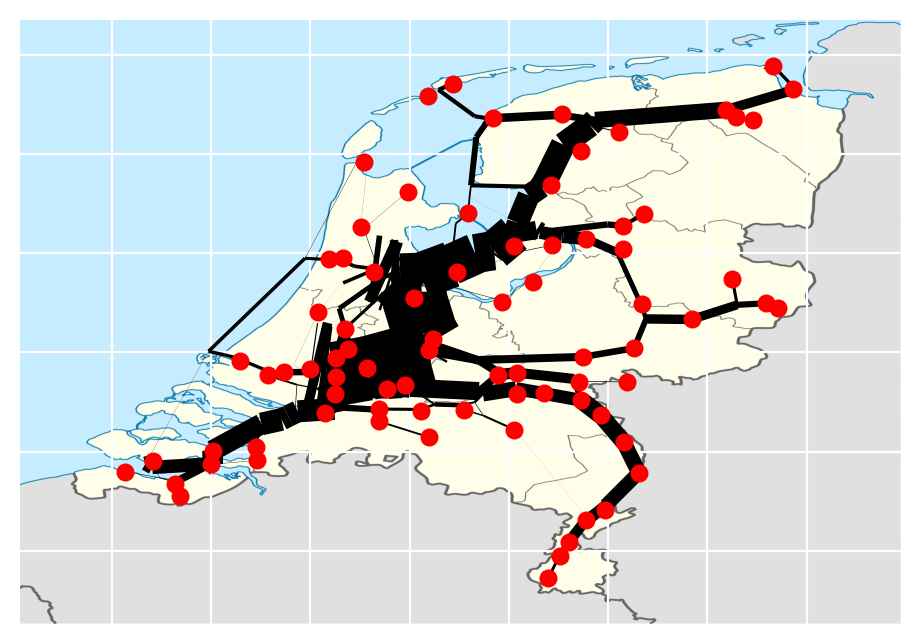

In [9]:
widths0 = plot_context(G, flows, 'passing_flow', 50000, scale=False)

In [10]:
df_links

source   target                            Name  Code      length_m  \
0    8865449  8861231    Vaarwegvak van 81 tot 81 - H  VI_A    366.299833   
1    8865449  8862813    Vaarwegvak van 80 tot 81 - H  VI_A    930.119949   
2    8865449  8867910                             NaN   NaN  26616.066119   
3    8866570  8863048  Vaarwegvak van 118 tot 121 - H  VI_C   3204.746699   
4    8866570  8863131  Vaarwegvak van 117 tot 118 - H  VI_C    831.617835   
..       ...      ...                             ...   ...           ...   
273  8860725  8860743                             NaN   NaN  20683.300289   
274  8861829  8861499    Vaarwegvak van 25 tot 31 - H   V_B   9207.827673   
275  8864435  8863518                             NaN   NaN  18698.984476   
276  8862106  8867986                             NaN   NaN  11000.829482   
277  8867258  8867901                             NaN   NaN   7802.775698   

     GeoType  subgraph  CoupledDepth  GeneralDepth  PushedLength  ...  \
0    section       0.0           NaN           NaN         193.0  ...   
1    section       0.0           NaN           NaN         193.0  ...   
2        NaN       NaN           NaN           NaN           NaN  ...   
3    section       0.0           4.4           4.4         229.5  ...   
4    section       0.0           4.4           4.4         229.5  ...   
..       ...       ...           ...           ...           ...  ...   
273      NaN       NaN           NaN           NaN           NaN  ...   
274  section       0.0           NaN           NaN           NaN  ...   
275      NaN       NaN           NaN           NaN           NaN  ...   
276      NaN       NaN           NaN           NaN           NaN  ...   
277      NaN       NaN           NaN           NaN           NaN  ...   

                                                   Wkt  SeaFairingWidth  \
0    LINESTRING (5.09475697850227 52.0024715385942,...              NaN   
1    LINESTRING (5.10314147453579 52.0030589346343,...              NaN   
2                                                  NaN              NaN   
3    LINESTRING (4.66917516502852 51.8293462000266,...              NaN   
4    LINESTRING (4.67101674887067 51.8220855012847,...              NaN   
..                                                 ...              ...   
273                                                NaN              NaN   
274  LINESTRING (5.33062130507903 52.4965969141035,...              NaN   
275                                                NaN              NaN   
276                                                NaN              NaN   
277                                                NaN              NaN   

    Id_navigability  Classification  CoupledWidth  PushedDepth  \
0           58392.0            CEMT           NaN          NaN   
1           58392.0            CEMT           NaN          NaN   
2               NaN             NaN           NaN          NaN   
3           37056.0            CEMT          23.5          4.4   
4           37056.0            CEMT          23.5          4.4   
..              ...             ...           ...          ...   
273             NaN             NaN           NaN          NaN   
274         36960.0            CEMT           NaN          NaN   
275             NaN             NaN           NaN          NaN   
276             NaN             NaN           NaN          NaN   
277             NaN             NaN           NaN          NaN   

     SeaFairingLength  WidePushedWidth  \
0                 NaN             22.9   
1                 NaN             22.9   
2                 NaN              NaN   
3                 NaN             34.4   
4                 NaN             34.4   
..                ...              ...   
273               NaN              NaN   
274               NaN              NaN   
275               NaN              NaN   
276               NaN              NaN   
277               NaN              NaN   

     

In [11]:
df_links = nx.to_pandas_edgelist(G)

In [12]:
flows = flow_computation(df_ivs, 100000, path_lengths, False)

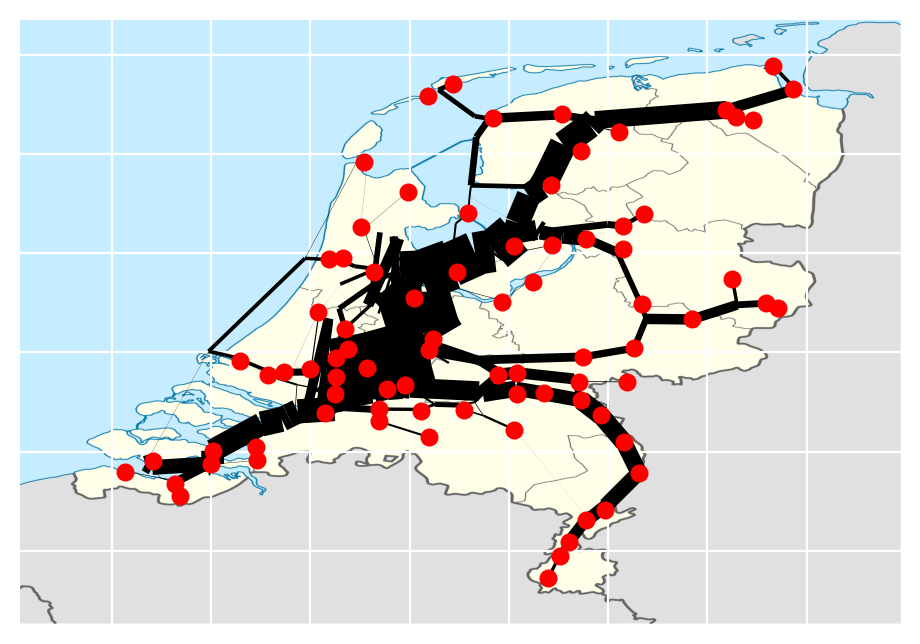

In [13]:
widths1 = plot_context(G, flows, 'passing_flow', 50000, scale=False)

In [14]:
round((sum(widths1.values())-sum(widths0.values()))/sum(widths0.values())*100, 2)

9.79

In [15]:
sum(widths0.values())

56775884.8364378

In [16]:
sum(widths1.values())

62331647.18784427

In [17]:
## Why does using non-individual speeds lead to different results?

In [18]:
ship_data = pd.read_excel('data/ship_types.xlsx')

## Some experiments

## Plot captured flow

## 60000

CFRLM:
MAXIMIZE
2703.5759068704283*Flow_captured_(('NLABL',_'NLRTM',_0),_('8863306',)) + 2703.5759068704283*Flow_captured_(('NLABL',_'NLRTM',_0),_('8866686',)) + 2212.1197716431006*Flow_captured_(('NLAER',_'NLLEY',_0),_('8864005',_'8863709')) + 2026.4622197119354*Flow_captured_(('NLAER',_'NLSWI',_0),_('8864005',_'8867258')) + 1421.2166782652046*Flow_captured_(('NLALM',_'NLHGL',_0),_('8866512',_'8864153')) + 15624.956869527025*Flow_captured_(('NLAMS',_'NLAER',_0),_('8866429',_'8864005')) + 2227.395968233117*Flow_captured_(('NLAMS',_'NLDHR',_0),_('8866429',_'8861625',_'8861568')) + 832.5368028995592*Flow_captured_(('NLAMS',_'NLIJM',_0),_('8862497',)) + 832.5368028995592*Flow_captured_(('NLAMS',_'NLIJM',_0),_('8866429',)) + 991.9932938966092*Flow_captured_(('NLBNB',_'NLHGL',_0),_('8866512',_'8864153')) + 494.8630379993027*Flow_captured_(('NLBON',_'NLSTI',_0),_('22638156',)) + 494.8630379993027*Flow_captured_(('NLBON',_'NLSTI',_0),_('8868208',)) + 3072.746109244969*Flow_captured_(('NLBZM',

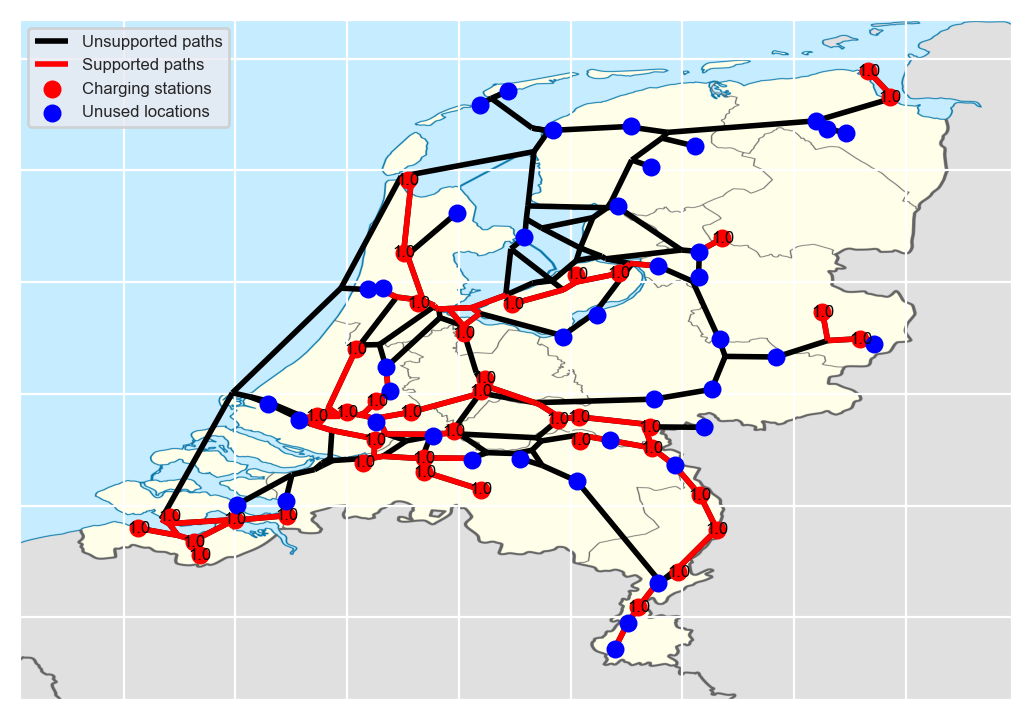

In [20]:
total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities1, non_zero_flows, routes_supported, paths, G, df_abm, df_random_out, max_flow = flow_refueling_location_model(60000, 40, 2500, 5, vis=True)

In [21]:
print("Fraction captured total:", round(fraction_captured_total,2))
print("Fraction serviceable:", round(serviceable_fraction,2))
print("Serviced fraction:", round(served_fraction,2))
print("Expected occupation:", round(max_flow / (40 * 2500),2))

Fraction captured total: 0.09
Fraction serviceable: 0.09
Serviced fraction: 0.99
Expected occupation: 2.66


In [22]:
sum(optimal_facilities1.values())

40.0

In [23]:
captured_flows = {i:sum(non_zero_flows[i]['flows']) for i in non_zero_flows.keys()}

In [24]:
captured_flows = {i:j*flows[i] for i,j in captured_flows.items()}

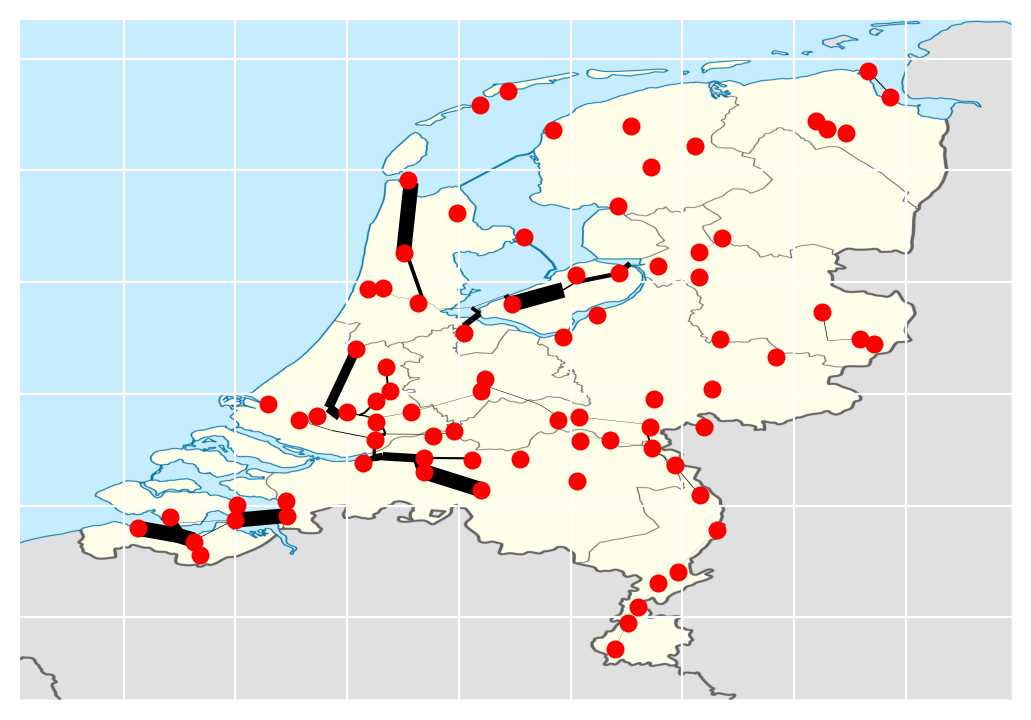

In [25]:
widths3 = plot_context(G, captured_flows, 'captured_flow_60000', 5)

In [26]:
widths3

{('8864153', '8860579'): 2661.5084469626313,
 ('8864153', '8868168'): 0.0,
 ('8868065', '8862419'): 0.0,
 ('8868065', '8866297'): 4277.3282170138955,
 ('8868065', '8863614'): 4277.3282170138955,
 ('8865920', '8864117'): 0.0,
 ('8864526', '8864005'): 4776.393402297339,
 ('8864526', '8862690'): 4776.393402297339,
 ('8864526', '8868457'): 0.0,
 ('8868208', '8861292'): 1288.033433744094,
 ('8868208', '8867148'): 1279.5912026453852,
 ('8860933', '8864167'): 0.0,
 ('8860933', '8863336'): 0.0,
 ('8860933', '8867031'): 0.0,
 ('8863354', '22638327'): 16983.621327869187,
 ('8863354', '8861687'): 16983.621327869187,
 ('8863354', '8862687'): 0.0,
 ('8863114', '22638019'): 14933.308272713055,
 ('8863114', '8864553'): 14933.308272713055,
 ('8863114', '8860623'): 0.0,
 ('8861840', '8863288'): 0.0,
 ('8861840', '8865143'): 0.0,
 ('8861840', '8863762'): 0.0,
 ('11309058', '11309119'): 0.0,
 ('11309058', '8865990'): 0.0,
 ('11309058', '8866775'): 0.0,
 ('8867046', '8862592'): 0.0,
 ('8867046', '8863360'

## 90000

CFRLM:
MAXIMIZE
2703.5759068704283*Flow_captured_(('NLABL',_'NLRTM',_0),_('8863306',)) + 2703.5759068704283*Flow_captured_(('NLABL',_'NLRTM',_0),_('8866686',)) + 2212.1197716431*Flow_captured_(('NLAER',_'NLLEY',_0),_('8863709',)) + 2212.1197716431*Flow_captured_(('NLAER',_'NLLEY',_0),_('8864005',)) + 2026.4622197119347*Flow_captured_(('NLAER',_'NLSWI',_0),_('8864005',_'8867258')) + 2958.486641160946*Flow_captured_(('NLALK',_'NLIJM',_0),_('8861625',_'8862497')) + 1421.2166782652046*Flow_captured_(('NLALM',_'NLHGL',_0),_('8864153',)) + 1421.2166782652046*Flow_captured_(('NLALM',_'NLHGL',_0),_('8866512',)) + 15624.956869527026*Flow_captured_(('NLAMS',_'NLAER',_0),_('8866429',_'8864005')) + 21.60326583221266*Flow_captured_(('NLAMS',_'NLBOT',_1),_('8863206',_'8866564',_'8866429')) + 21.60326583221266*Flow_captured_(('NLAMS',_'NLBOT',_1),_('8863475',_'8866564',_'8866429')) + 67.67696184470229*Flow_captured_(('NLAMS',_'NLBOT',_2),_('8863206',_'8863360',_'8866429')) + 67.67696184470229*Flow_ca

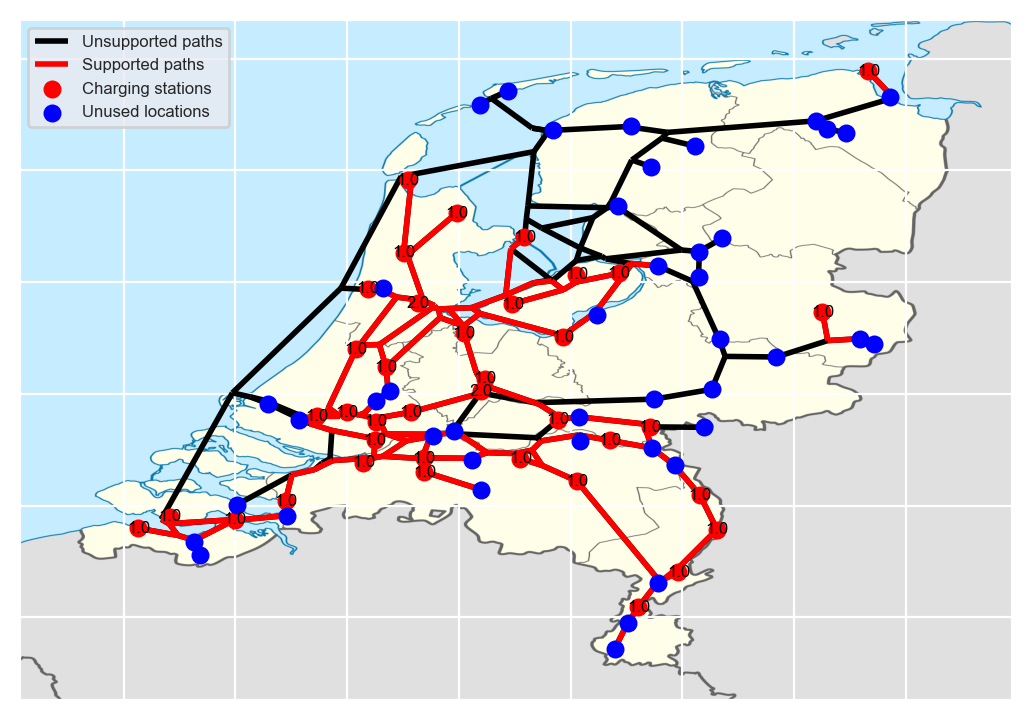

In [27]:
total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities2, non_zero_flows, routes_supported, paths, G, df_abm, df_random_out, max_flow = flow_refueling_location_model(90000, 40, 2500, 5, vis=True)

In [28]:
print("Fraction captured total:", round(fraction_captured_total,2))
print("Fraction serviceable:", round(serviceable_fraction,2))
print("Serviced fraction:", round(served_fraction,2))
print("Expected occupation:", round(max_flow / (40 * 2500),2))

Fraction captured total: 0.24
Fraction serviceable: 0.24
Serviced fraction: 0.99
Expected occupation: 7.02


In [29]:
sum(optimal_facilities2.values())

40.0

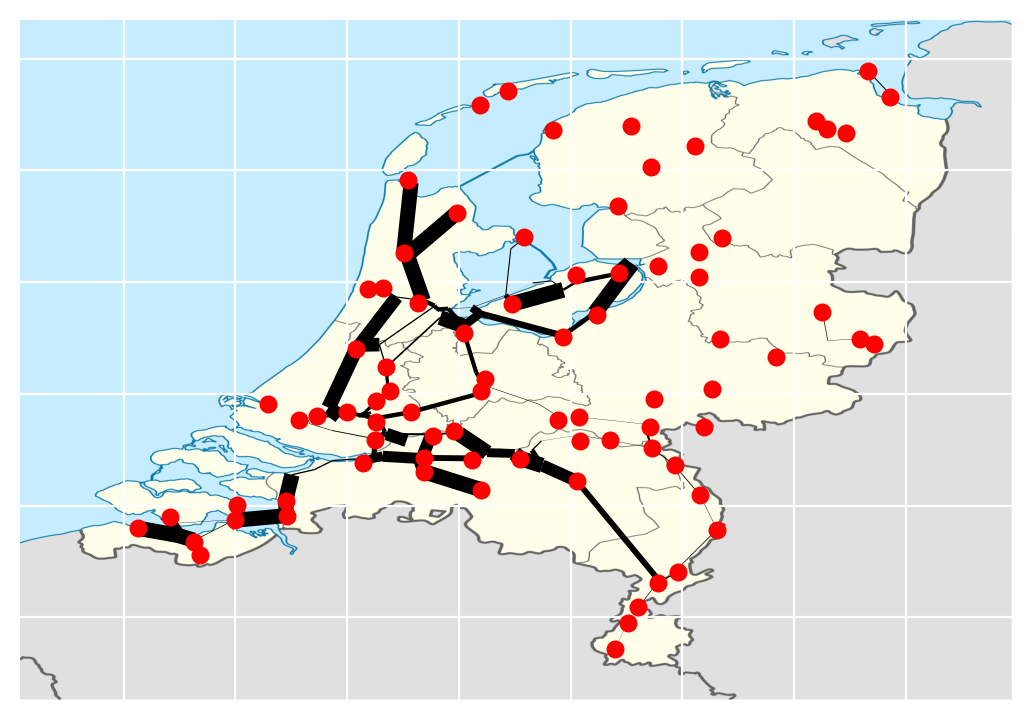

In [30]:
captured_flows = {i: sum(non_zero_flows[i]['flows']) for i in non_zero_flows.keys()}
captured_flows = {i: j * flows[i] for i, j in captured_flows.items()}
widths4 = plot_context(G, captured_flows, 'captured_flow_90000', 5)

## 120000

CFRLM:
MAXIMIZE
2703.5759068704283*Flow_captured_(('NLABL',_'NLRTM',_0),_('8863306',)) + 2703.5759068704283*Flow_captured_(('NLABL',_'NLRTM',_0),_('8866686',)) + 2212.1197716431006*Flow_captured_(('NLAER',_'NLLEY',_0),_('8863709',)) + 2212.1197716431006*Flow_captured_(('NLAER',_'NLLEY',_0),_('8864005',)) + 11277.026528683966*Flow_captured_(('NLAER',_'NLNIE',_0),_('8864005',_'8863360')) + 11277.026528683966*Flow_captured_(('NLAER',_'NLNIE',_0),_('8867538',_'8864005')) + 29584.428391712176*Flow_captured_(('NLAER',_'NLRTM',_0),_('8864005',_'8863360')) + 29584.428391712176*Flow_captured_(('NLAER',_'NLRTM',_0),_('8867538',_'8864005')) + 2026.4622197119354*Flow_captured_(('NLAER',_'NLSWI',_0),_('8864005',)) + 2026.4622197119354*Flow_captured_(('NLAER',_'NLSWI',_0),_('8867258',)) + 2958.486641160946*Flow_captured_(('NLALK',_'NLIJM',_0),_('8861625',_'8862497')) + 1421.2166782652046*Flow_captured_(('NLALM',_'NLHGL',_0),_('8864153',)) + 1421.2166782652046*Flow_captured_(('NLALM',_'NLHGL',_0),_('

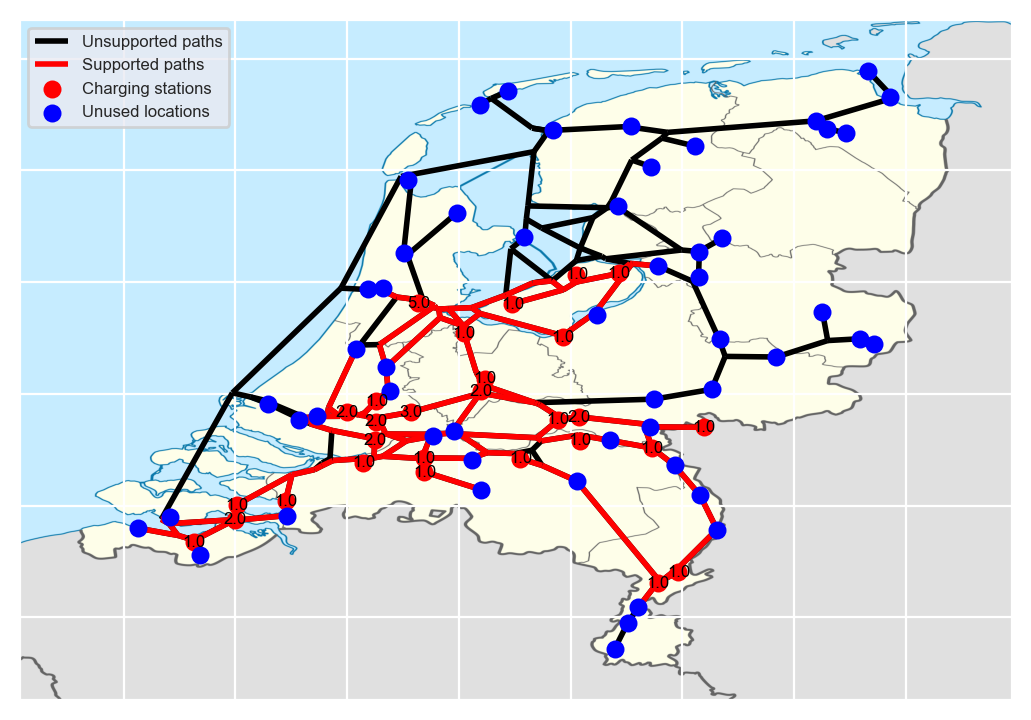

In [31]:
total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities3, non_zero_flows, routes_supported, paths, G, df_abm, df_random_out, max_flow = flow_refueling_location_model(120000, 40, 2500, 5, vis=True)

In [32]:
print("Fraction captured total:", round(fraction_captured_total, 2))
print("Fraction serviceable:", round(serviceable_fraction, 2))
print("Fraction serviced:", round(served_fraction, 2))
print("Expected occupation:", round(max_flow / (40 * 2500), 2))

Fraction captured total: 0.51
Fraction serviceable: 0.53
Fraction serviced: 0.96
Expected occupation: 14.93


In [33]:
sum(optimal_facilities3.values())

40.0

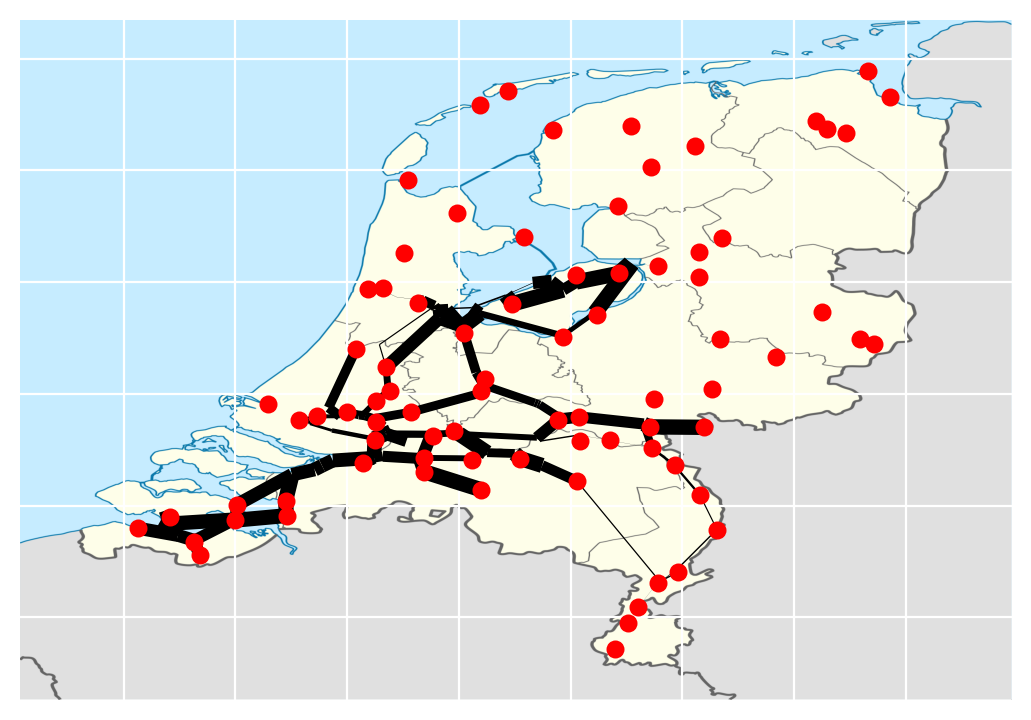

In [34]:
captured_flows = {i: sum(non_zero_flows[i]['flows']) for i in non_zero_flows.keys()}
captured_flows = {i: j * flows[i] for i, j in captured_flows.items()}
widths5 = plot_context(G, captured_flows, 'captured_flow_120000', 5)

## 150000

CFRLM:
MAXIMIZE
2703.5759068704288*Flow_captured_(('NLABL',_'NLRTM',_0),_('8863306',)) + 2703.5759068704288*Flow_captured_(('NLABL',_'NLRTM',_0),_('8866686',)) + 2212.1197716431*Flow_captured_(('NLAER',_'NLLEY',_0),_('8863709',)) + 2212.1197716431*Flow_captured_(('NLAER',_'NLLEY',_0),_('8864005',)) + 11277.026528683968*Flow_captured_(('NLAER',_'NLNIE',_0),_('8864005',_'8863360')) + 11277.026528683968*Flow_captured_(('NLAER',_'NLNIE',_0),_('8867538',_'8864005')) + 29584.428391712176*Flow_captured_(('NLAER',_'NLRTM',_0),_('8863306',_'8864005')) + 29584.428391712176*Flow_captured_(('NLAER',_'NLRTM',_0),_('8864005',_'8863360')) + 29584.428391712176*Flow_captured_(('NLAER',_'NLRTM',_0),_('8867538',_'8864005')) + 2026.4622197119354*Flow_captured_(('NLAER',_'NLSWI',_0),_('8864005',)) + 2026.4622197119354*Flow_captured_(('NLAER',_'NLSWI',_0),_('8867258',)) + 2958.4866411609455*Flow_captured_(('NLALK',_'NLIJM',_0),_('8861625',)) + 2958.4866411609455*Flow_captured_(('NLALK',_'NLIJM',_0),_('88624

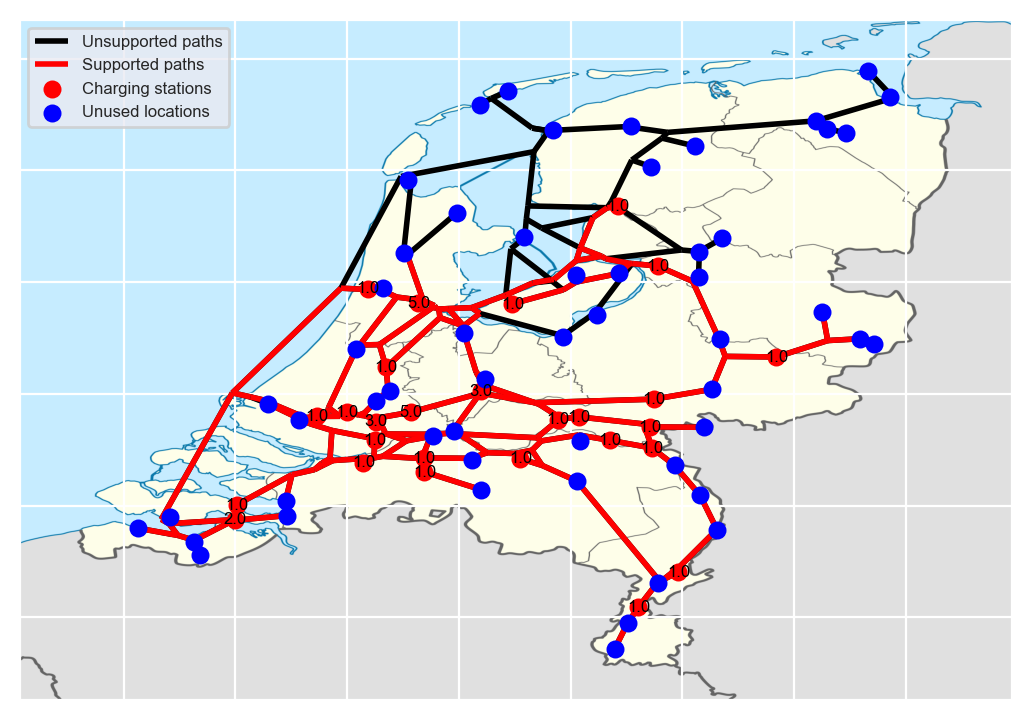

In [35]:
total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities4, non_zero_flows, routes_supported, paths, G, df_abm, df_random_out, max_flow = flow_refueling_location_model(150000, 40, 2500, 5, vis=True, additional_nodes=0)

In [36]:
print("Fraction captured total:", round(fraction_captured_total, 2))
print("Fraction serviceable:", round(serviceable_fraction, 2))
print("Fraction serviced:", round(served_fraction, 2))
print("Expected occupation:", round(max_flow / (40 * 2500), 2))

Fraction captured total: 0.68
Fraction serviceable: 0.75
Fraction serviced: 0.92
Expected occupation: 20.14


In [37]:
sum(optimal_facilities4.values())

40.0

plotting does not work with extra nodes yet now...

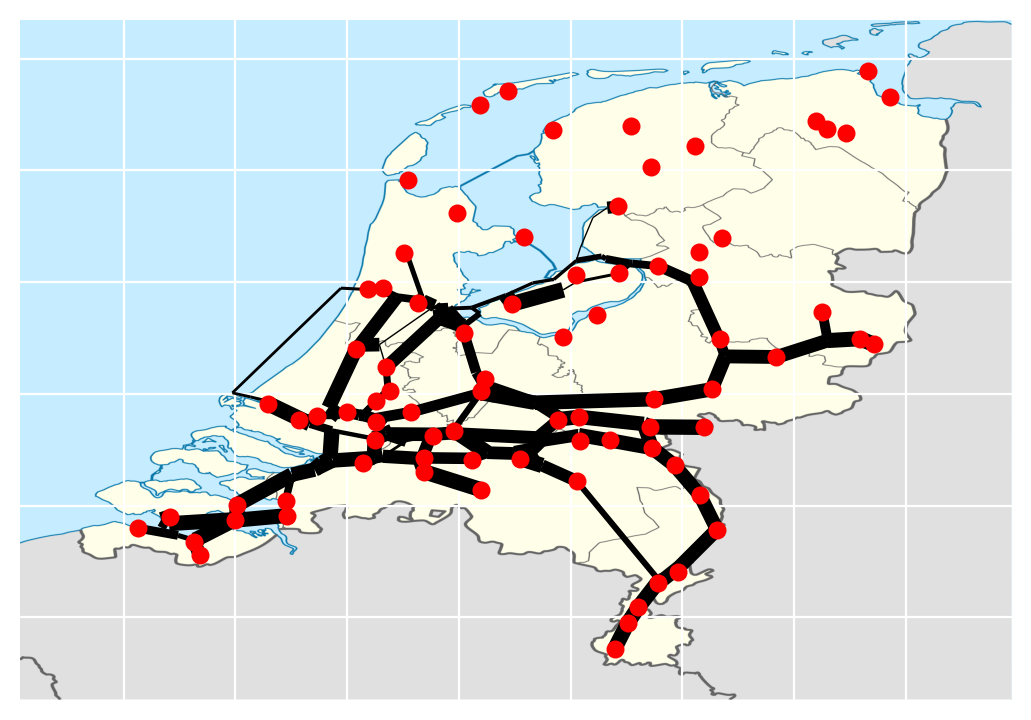

In [38]:
captured_flows = {i: sum(non_zero_flows[i]['flows']) for i in non_zero_flows.keys()}
captured_flows = {i: j * flows[i] for i, j in captured_flows.items()}
widths6 = plot_context(G, captured_flows, 'captured_flow_150000', 5)

In [76]:
widths6

{('8864153', '8860579'): 123268.18231944245,
 ('8864153', '8868168'): 17412.719942476473,
 ('8868065', '8862419'): 7074.977748702848,
 ('8868065', '8866297'): 11352.305965716743,
 ('8868065', '8863614'): 4277.3282170138955,
 ('8865920', '8864117'): 2960.348295230126,
 ('8864526', '8864005'): 4776.393402297339,
 ('8864526', '8862690'): 47912.15756262623,
 ('8864526', '8868457'): 43135.76416032889,
 ('8868208', '8861292'): 209596.04089859396,
 ('8868208', '8867148'): 120003.24292114456,
 ('8860933', '8864167'): 1593.5992432517073,
 ('8860933', '8863336'): 1593.5992432517073,
 ('8860933', '8867031'): 0.0,
 ('8863354', '22638327'): 99188.98708709386,
 ('8863354', '8861687'): 107003.99731543894,
 ('8863354', '8862687'): 7815.010228345091,
 ('8863114', '22638019'): 38848.359345554,
 ('8863114', '8864553'): 329924.33053301706,
 ('8863114', '8860623'): 301810.7484795913,
 ('8861840', '8863288'): 0.0,
 ('8861840', '8865143'): 43417.183938040784,
 ('8861840', '8863762'): 43417.183938040784,
 ('1

## Compare outcomes in detail

In [39]:
df = pd.DataFrame([optimal_facilities1,optimal_facilities2,optimal_facilities3,optimal_facilities4])

In [40]:
df = df.T

In [41]:
df=df.rename(columns={0:'60km', 1:'90km', 2:'120km', 3:'150km'})

In [42]:
df.loc[df['60km']!=0].sum()

60km     40.0
90km     30.0
120km    32.0
150km    28.0
dtype: float64

In [43]:
df.loc[df['90km']!=0].sum()

60km     28.0
90km     40.0
120km    31.0
150km    33.0
dtype: float64

In [44]:
df.loc[df['120km']!=0].sum()

60km     21.0
90km     22.0
120km    40.0
150km    30.0
dtype: float64

In [45]:
df.loc[df['150km']!=0].sum()

60km     17.0
90km     22.0
120km    29.0
150km    40.0
dtype: float64

In [46]:
df_always = df.loc[(df>0).all(axis=1)]
df_always

60km  90km  120km  150km
22638146   1.0   1.0    1.0    1.0
30984595   1.0   1.0    1.0    1.0
8862448    1.0   1.0    1.0    1.0
8862776    1.0   1.0    3.0    5.0
8863306    1.0   1.0    2.0    1.0
8863818    1.0   1.0    1.0    1.0
8864005    1.0   1.0    1.0    1.0
8866429    1.0   2.0    5.0    5.0
8866893    1.0   1.0    1.0    1.0
8867130    1.0   1.0    2.0    1.0
8867392    1.0   2.0    2.0    3.0
8867824    1.0   1.0    2.0    2.0

In [80]:
df_all_with = pickle.load(open('final_results/df_all_with_clean.p', "rb"))
df_all_without = pickle.load(open('final_results/df_all_without_clean.p', "rb"))

In [81]:
df_all_without

r scenario_var   p scenario policy model    total_flow  \
0     70.0            0   1      100      0  frlm  2.941841e+06   
1     70.0            1   1      101      0  frlm  2.941841e+06   
2     70.0            2   1      102      0  frlm  2.941841e+06   
3    110.0            0   1      103      0  frlm  2.941841e+06   
4    110.0            1   1      104      0  frlm  2.941841e+06   
..     ...          ...  ..      ...    ...   ...           ...   
564  150.0            0  63      106     62  frlm  2.941841e+06   
573  150.0            0  64      106     63  frlm  2.941841e+06   
582  150.0            0  65      106     64  frlm  2.941841e+06   
591  150.0            0  66      106     65  frlm  2.941841e+06   
600  150.0            0  67      106     66  frlm  2.941841e+06   

     fraction_captured_total  serviceable_fraction  served_fraction  \
0                   0.016316              0.103069         0.158305   
1                   0.017516              0.103069         0.169945   
2                   0.017516              0.103069         0.169945   
3                   0.016316              0.409292         0.039865   
4                   0.027191              0.409292         0.066435   
..                       ...                   ...              ...   
564                 0.713657              0.746216         0.956368   
573                 0.714429              0.746216         0.957403   
582                 0.715180              0.746216         0.958409   
591                 0.715849              0.746216         0.959306   
600                 0.716131              0.746216         0.959684   

                                    optimal_facilities  \
0    {'22637863': 0.0, '22638019': 0.0, '22638146':...   
1    {'22637863': 0.0, '22638019': 0.0, '22638146':...   
2    {'22637863': 0.0, '22638019': 0.0, '22638146':...   
3    {'22637863': 0.0, '22638019': 0.0, '22638146':...   
4    {'22637863': 0.0, '22638019': 0.0, '22638146':...   
..                                                 ...   
564  {'22637863': 0.0, '22638019': 0.0, '22638146':...   
573  {'22637863': 0.0, '22638019': 0.0, '22638146':...   
582  {'22637863': 0.0, '22638019': 0.0, '22638146':...   
591  {'22637863': 0.0, '22638019': 0.0, '22638146':...   
600  {'22637863': 0.0, '22638019': 0.0, '22638146':...   

                                        non_zero_flows  add_nodes_used  \
0    {('NLABL', 'NLRTM', 0): {'combinations': [['88...             0.0   
1    {('NLABL', 'NLRTM', 0): {'combinations': [['88...             0.0   
2    {('NLABL', 'NLRTM', 0): {'combinations': [['88...             0.0   
3    {('NLABL', 'NLRTM', 0): {'combinations': [['88...             0.0   
4    {('NLABL', 'NLRTM', 0): {'combinations': [['88...             0.0   
..                                                 ...             ...   
564  {('NLABL', 'NLRTM', 0): {'combinations': [['88...             0.0   
573  {('NLABL', 'NLRTM', 0): {'combinations': [['88...             0.0   
582  {('NLABL', 'NLRTM', 0): {'combinations': [['88...             0.0   
591  {('NLABL', 'NLRTM', 0): {'combinations': [['88...             0.0   
600  {('NLABL', 'NLRTM', 0): {'combinations': [['88...             0.0   

     no_sited      c  m  
0         1.0   2000  5  
1         1.0   3333  3  
2         1.0  10000  1  
3         1.0   2000  5  
4         1.0   3333  3  
..        ...    ... ..  
564      63.0   2000  5  
573      64.0   2000  5  
582      65.0   2000  5  
591      66.0   2000  5  
600      67.0   2000  5  

[433 rows x 16 columns]

In [98]:
df = df_all_with

In [99]:
df

r   p      c  m  fraction_captured_total  serviceable_fraction  \
0     70.0  10   2000  5                 0.163163              0.578467   
1     70.0  20   2000  5                 0.300119              0.578467   
2     70.0  30   2000  5                 0.400060              0.578467   
3     70.0  40   2000  5                 0.482912              0.578467   
4     70.0  50   2000  5                 0.535415              0.578467   
..     ...  ..    ... ..                      ...                   ...   
170  150.0   5  10000  1                 0.354167              0.991757   
171  150.0  15  10000  1                 0.744481              0.991757   
172  150.0  25  10000  1                 0.922861              0.991757   
173  150.0  35  10000  1                 0.981279              0.991757   
174  150.0  45  10000  1                 0.991728              0.991757   

     served_fraction                                 optimal_facilities  \
0           0.282061  {'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....   
1           0.518819  {'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....   
2           0.691587  {'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....   
3           0.834813  {'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....   
4           0.925576  {'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....   
..               ...                                                ...   
170         0.357111  {'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....   
171         0.750668  {'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....   
172         0.930532  {'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....   
173         0.989435  {'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....   
174         0.999971  {'101': 0.0, '102': 1.0, '103': 0.0, '104': 0....   

                                        non_zero_flows  add_nodes_used  \
0    {('NLABL', 'NLRTM', 0): {'combinations': [['88...             3.0   
1    {('NLABL', 'NLRTM', 0): {'combinations': [['88...             4.0   
2    {('NLABL', 'NLRTM', 0): {'combinations': [['88...             8.0   
3    {('NLABL', 'NLRTM', 0): {'combinations': [['88...            12.0   
4    {('NLABL', 'NLRTM', 0): {'combinations': [['88...            14.0   
..                                                 ...             ...   
170  {('NLABL', 'NLRTM', 0): {'combinations': [['88...             1.0   
171  {('NLABL', 'NLRTM', 0): {'combinations': [['88...             7.0   
172  {('NLABL', 'NLRTM', 0): {'combinations': [['88...            14.0   
173  {('NLABL', 'NLRTM', 0): {'combinations': [['88...            16.0   
174  {('NLABL', 'NLRTM', 0): {'combinations': [['88...            18.0   

     no_sited  
0        10.0  
1        20.0  
2        30.0  
3        40.0  
4        50.0  
..        ...  
170       5.0  
171      15.0  
172      25.0  
173      35.0  
174      45.0  

[121 rows x 11 columns]

In [100]:
df = pd.DataFrame()
for i, row in df_all_with.iterrows():
    a = pd.DataFrame(row['optimal_facilities'].values(),row['optimal_facilities'].keys())
    df = pd.concat([df,a],axis=1)

In [101]:
df

0    0    0    0    0    0    0    0    0    0  ...    0    0    0  \
101      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
102      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
103      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
104      0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  ...  0.0  0.0  0.0   
105      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
8867740  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
8867824  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  1.0  1.0   
8868168  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
8868191  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  ...  0.0  0.0  1.0   
8868208  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  ...  0.0  0.0  1.0   

           0    0    0    0    0    0    0  
101      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
102      0.0  0.0  0.0  0.0  0.0  0.0  1.0  
103      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
104      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
105      1.0  1.0  0.0  0.0  0.0  0.0  0.0  
...      ...  ...  ...  ...  ...  ...  ...  
8867740  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
8867824  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
8868168  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
8868191  1.0  1.0  0.0  1.0  1.0  1.0  1.0  
8868208  1.0  1.0  0.0  1.0  1.0  1.0  1.0  

[131 rows x 121 columns]

### Density plots

In [103]:
sum(node_scales.values())

4495.000000471348

In [106]:
# we want to scale all the points with the total number of stations
scale_factor=4*0.41117819246249543
node_scales = dict(df.sum(axis=1))
scaled_widths = {i:(node_scales[i]/scale_factor) for i in node_scales.keys()}


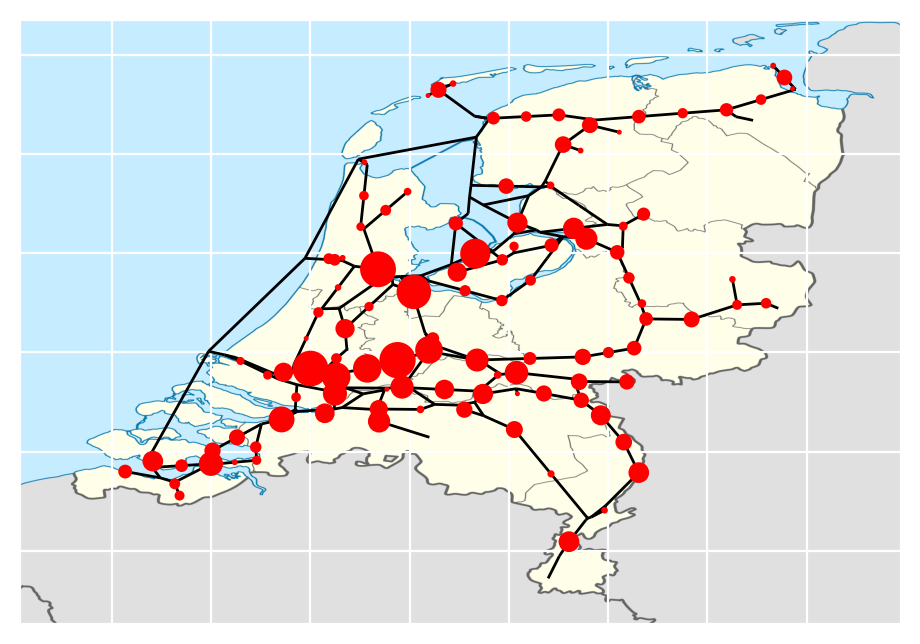

In [107]:
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_nodes(G,pos_dict,
                       nodelist=scaled_widths.keys(),
                       node_size=list(scaled_widths.values()),
                       node_color='r',
                       alpha=1)

nx.draw_networkx_edges(G,pos_dict)
img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53
ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])
plt.show()

In [49]:
df_always.index

Index(['22638146', '30984595', '8862448', '8862776', '8863306', '8863818',
       '8864005', '8866429', '8866893', '8867130', '8867392', '8867824'],
      dtype='object')

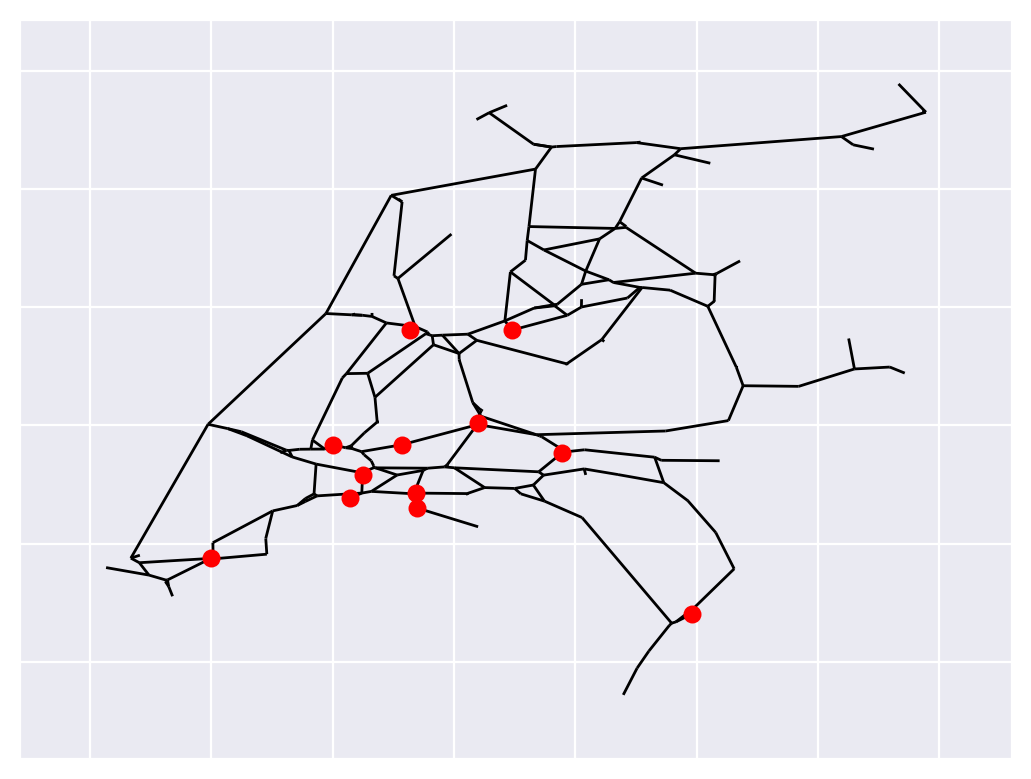

In [50]:
plt.subplots(dpi=200)
nx.draw_networkx_nodes(G,pos_dict,
                       nodelist=list(df_always.index),
                       node_size=30,
                       node_color='r',
                       alpha=1)

nx.draw_networkx_edges(G,pos_dict)

## Extreme values

### Max range 1,000,000, 40 modules

CFRLM:
MAXIMIZE
2703.5759068704288*Flow_captured_(('NLABL',_'NLRTM',_0),_('8863306',)) + 2703.5759068704288*Flow_captured_(('NLABL',_'NLRTM',_0),_('8866686',)) + 2212.1197716431*Flow_captured_(('NLAER',_'NLLEY',_0),_('8863709',)) + 2212.1197716431*Flow_captured_(('NLAER',_'NLLEY',_0),_('8864005',)) + 11277.026528683964*Flow_captured_(('NLAER',_'NLNIE',_0),_('8863360',)) + 11277.026528683964*Flow_captured_(('NLAER',_'NLNIE',_0),_('8864005',)) + 11277.026528683964*Flow_captured_(('NLAER',_'NLNIE',_0),_('8867538',)) + 29584.428391712187*Flow_captured_(('NLAER',_'NLRTM',_0),_('8863306',)) + 29584.428391712187*Flow_captured_(('NLAER',_'NLRTM',_0),_('8863360',)) + 29584.428391712187*Flow_captured_(('NLAER',_'NLRTM',_0),_('8864005',)) + 29584.428391712187*Flow_captured_(('NLAER',_'NLRTM',_0),_('8867538',)) + 2026.462219711935*Flow_captured_(('NLAER',_'NLSWI',_0),_('8864005',)) + 2026.462219711935*Flow_captured_(('NLAER',_'NLSWI',_0),_('8867258',)) + 2958.4866411609446*Flow_captured_(('NLALK',

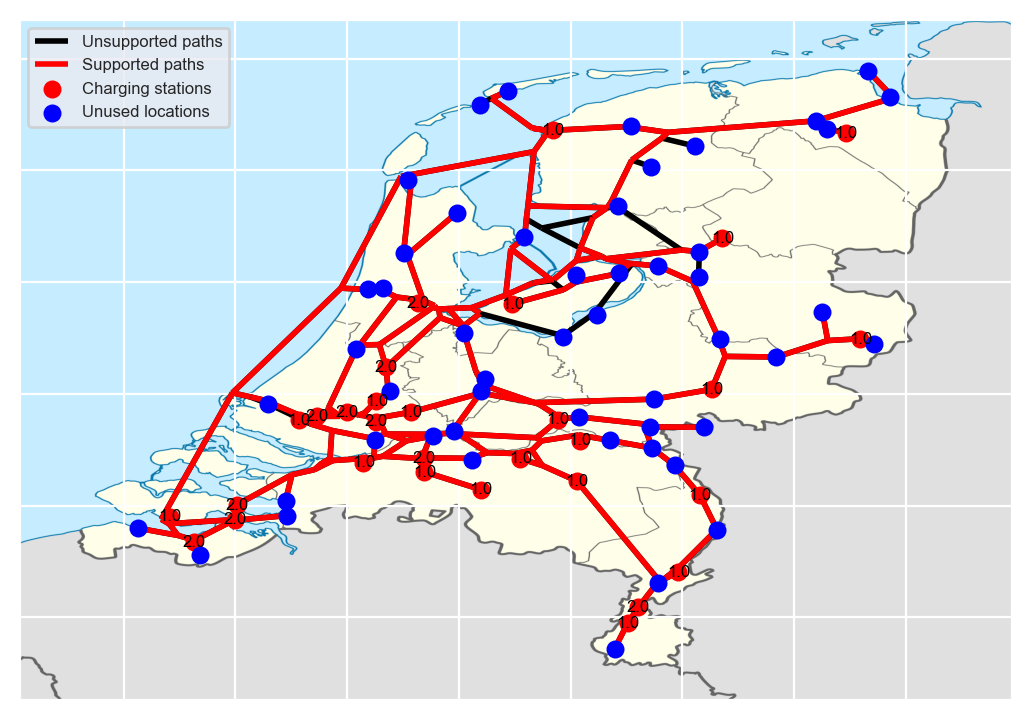

In [51]:
total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities, non_zero_flows, routes_supported, paths, G, df_abm, df_random_out, max_flow = flow_refueling_location_model(1000000, 40, 1000, 2, vis=True)

In [52]:
print("Fraction captured total:", round(fraction_captured_total, 2))
print("Fraction serviceable:", round(serviceable_fraction, 2))
print("Fraction serviced:", round(served_fraction, 2))
print("Expected occupation:", round(max_flow / (40 * 1000), 2))

Fraction captured total: 0.33
Fraction serviceable: 1.0
Fraction serviced: 0.33
Expected occupation: 24.0


In [53]:
sum(optimal_facilities.values())

40.0

In [54]:
routes_supported

146.0

In [55]:
for route, combi_flow in non_zero_flows.items():
    print(sum(combi_flow['flows']))

1.0
1.0
1.0
1.0
1.0
0.89189701
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.93321438
1.0
1.0
1.0
0.11425705
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.28658985
1.0
1.0
1.0
1.0
1.0
0.23104866
1.0
1.0
0.9077079530000001
1.0
0.95735762
1.0
1.0
1.0
1.0
1.0
1.0
0.70507875
1.0
1.0
1.0
0.355192995
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.78222421
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.91561242
1.0
1.0
0.86625075
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.995148
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.7885200800000001
0.50304132
1.0
1.0
0.93714279
0.34444432
1.0
0.19398805
0.098140339
1.0
1.0
1.0
1.0
0.55922826
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.5909257889999999
1.0
1.0
1.0
0.999999993
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.55390602
1.0
1.0
1.0
1.0


In [56]:
max_flow

959999.9993679216

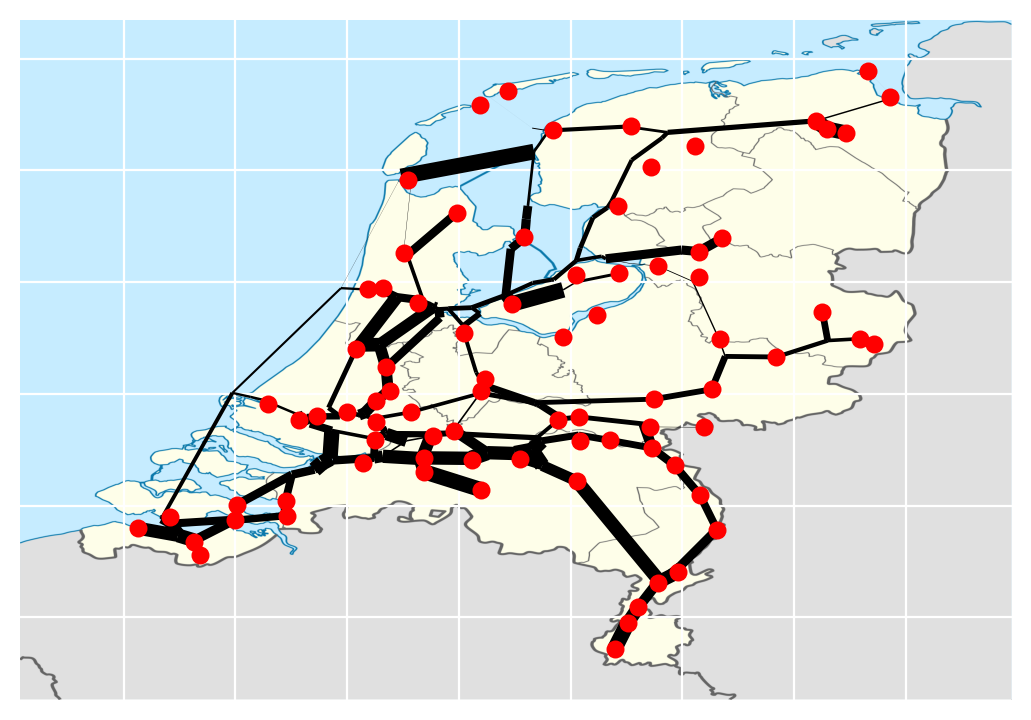

In [57]:
captured_flows = {i: sum(non_zero_flows[i]['flows']) for i in non_zero_flows.keys()}
captured_flows = {i: j * flows[i] for i, j in captured_flows.items()}
widths7 = plot_context(G, captured_flows, 'captured_flow_1mln', 5)

In [58]:
flow_cols = [col for col in df_links.columns if 'flow' in col]

In [59]:
flow_cols

['passing_flow',
 'captured_flow_60000',
 'captured_flow_90000',
 'captured_flow_120000',
 'captured_flow_150000',
 'captured_flow_1mln']

In [60]:
df_links[flow_cols].sum()

passing_flow            6.233165e+07
captured_flow_60000     2.722831e+06
captured_flow_90000     1.090341e+07
captured_flow_120000    2.900691e+07
captured_flow_150000    4.132096e+07
captured_flow_1mln      2.140859e+07
dtype: float64

### Single station with unlimited capacity and range

CFRLM:
MAXIMIZE
2703.5759068704288*Flow_captured_(('NLABL',_'NLRTM',_0),_('8863306',)) + 2703.5759068704288*Flow_captured_(('NLABL',_'NLRTM',_0),_('8866686',)) + 2212.1197716431*Flow_captured_(('NLAER',_'NLLEY',_0),_('8863709',)) + 2212.1197716431*Flow_captured_(('NLAER',_'NLLEY',_0),_('8864005',)) + 11277.026528683964*Flow_captured_(('NLAER',_'NLNIE',_0),_('8863360',)) + 11277.026528683964*Flow_captured_(('NLAER',_'NLNIE',_0),_('8864005',)) + 11277.026528683964*Flow_captured_(('NLAER',_'NLNIE',_0),_('8867538',)) + 29584.428391712187*Flow_captured_(('NLAER',_'NLRTM',_0),_('8863306',)) + 29584.428391712187*Flow_captured_(('NLAER',_'NLRTM',_0),_('8863360',)) + 29584.428391712187*Flow_captured_(('NLAER',_'NLRTM',_0),_('8864005',)) + 29584.428391712187*Flow_captured_(('NLAER',_'NLRTM',_0),_('8867538',)) + 2026.462219711935*Flow_captured_(('NLAER',_'NLSWI',_0),_('8864005',)) + 2026.462219711935*Flow_captured_(('NLAER',_'NLSWI',_0),_('8867258',)) + 2958.4866411609446*Flow_captured_(('NLALK',

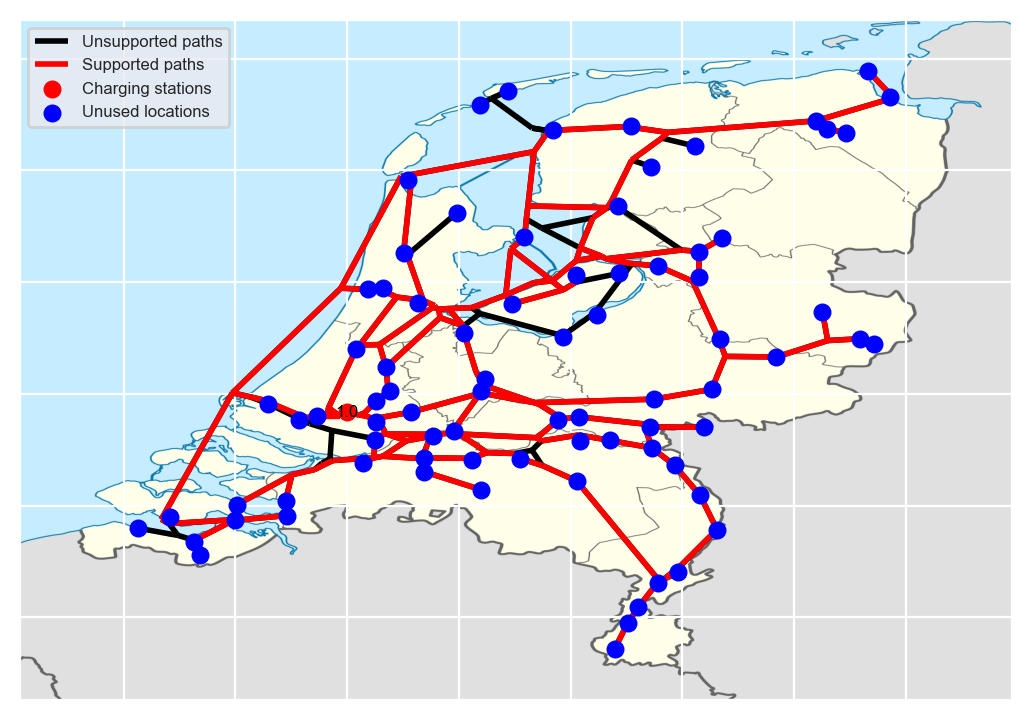

In [61]:
total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities, non_zero_flows, routes_supported, paths, G, df_abm, df_random_out, max_flow = flow_refueling_location_model(1000000, 1, 10e12, 2, vis=True)

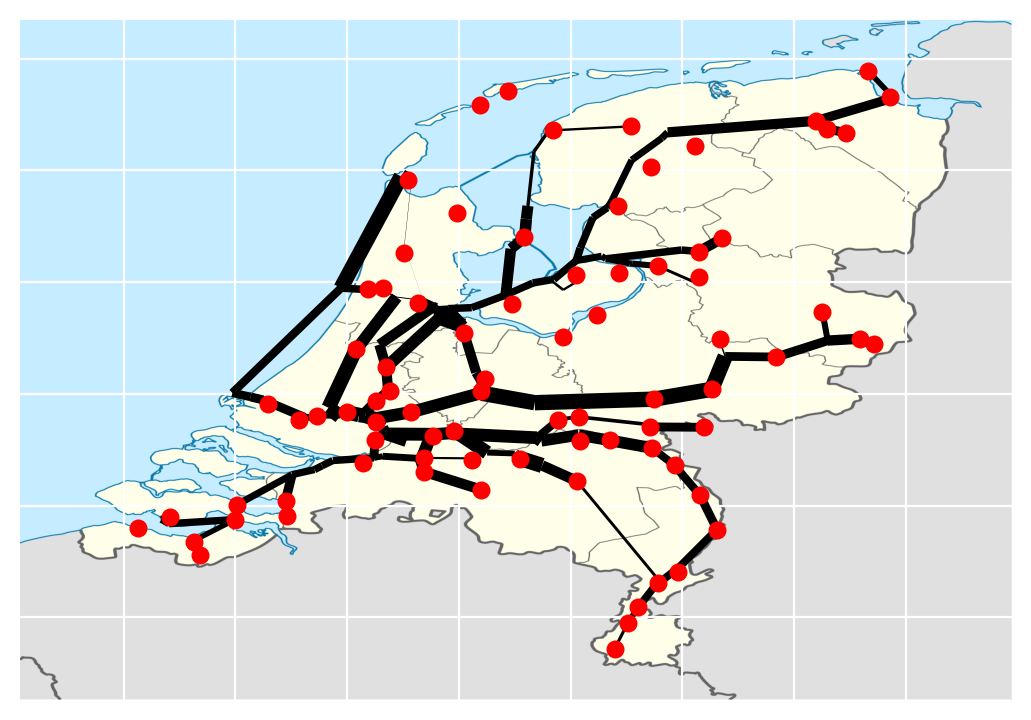

In [62]:
captured_flows = {i: sum(non_zero_flows[i]['flows']) for i in non_zero_flows.keys()}
captured_flows = {i: j * flows[i] for i, j in captured_flows.items()}
widths7 = plot_context(G, captured_flows, 'captured_flow_1mln_single', 5)

In [63]:
print("Fraction captured total:", round(fraction_captured_total, 2))
print("Fraction serviceable:", round(serviceable_fraction, 2))
print("Fraction serviced:", round(served_fraction, 2))
print("Charging:", round(max_flow / (1 * 10e12), 2))

Fraction captured total: 0.58
Fraction serviceable: 1.0
Fraction serviced: 0.58
Charging: 0.0


In [64]:
non_zero_flows

{('NLABL', 'NLRTM', 0): {'combinations': [['8863306']], 'flows': [1.0]},
 ('NLAER', 'NLRTM', 0): {'combinations': [['8863306']], 'flows': [1.0]},
 ('NLBON', 'NLRTM', 0): {'combinations': [['8863306']], 'flows': [1.0]},
 ('NLBON', 'NLRTM', 1): {'combinations': [['8863306']], 'flows': [1.0]},
 ('NLBZM', 'NLRTM', 0): {'combinations': [['8863306']], 'flows': [1.0]},
 ('NLBZM', 'NLRTM', 1): {'combinations': [['8863306']], 'flows': [1.0]},
 ('NLCUY', 'NLRTM', 0): {'combinations': [['8863306']], 'flows': [1.0]},
 ('NLCUY', 'NLRTM', 1): {'combinations': [['8863306']], 'flows': [1.0]},
 ('NLDHR', 'NLRTM', 0): {'combinations': [['8863306']], 'flows': [1.0]},
 ('NLDHR', 'NLRTM', 1): {'combinations': [['8863306']], 'flows': [1.0]},
 ('NLDOR', 'NLRTM', 0): {'combinations': [['8863306']], 'flows': [1.0]},
 ('NLDOR', 'NLRTM', 1): {'combinations': [['8863306']], 'flows': [1.0]},
 ('NLEEM', 'NLRTM', 1): {'combinations': [['8863306']], 'flows': [1.0]},
 ('NLEEM', 'NLRTM', 2): {'combinations': [['8863306

### Single station, limited capacity, range of 60000, 90000, 120000, and 150000

CFRLM:
MAXIMIZE
2703.5759068704283*Flow_captured_(('NLABL',_'NLRTM',_0),_('8863306',)) + 2703.5759068704283*Flow_captured_(('NLABL',_'NLRTM',_0),_('8866686',)) + 2212.1197716431006*Flow_captured_(('NLAER',_'NLLEY',_0),_('8864005',_'8863709')) + 2026.4622197119354*Flow_captured_(('NLAER',_'NLSWI',_0),_('8864005',_'8867258')) + 1421.2166782652046*Flow_captured_(('NLALM',_'NLHGL',_0),_('8866512',_'8864153')) + 15624.956869527025*Flow_captured_(('NLAMS',_'NLAER',_0),_('8866429',_'8864005')) + 2227.395968233117*Flow_captured_(('NLAMS',_'NLDHR',_0),_('8866429',_'8861625',_'8861568')) + 832.5368028995592*Flow_captured_(('NLAMS',_'NLIJM',_0),_('8862497',)) + 832.5368028995592*Flow_captured_(('NLAMS',_'NLIJM',_0),_('8866429',)) + 991.9932938966092*Flow_captured_(('NLBNB',_'NLHGL',_0),_('8866512',_'8864153')) + 494.8630379993027*Flow_captured_(('NLBON',_'NLSTI',_0),_('22638156',)) + 494.8630379993027*Flow_captured_(('NLBON',_'NLSTI',_0),_('8868208',)) + 3072.746109244969*Flow_captured_(('NLBZM',

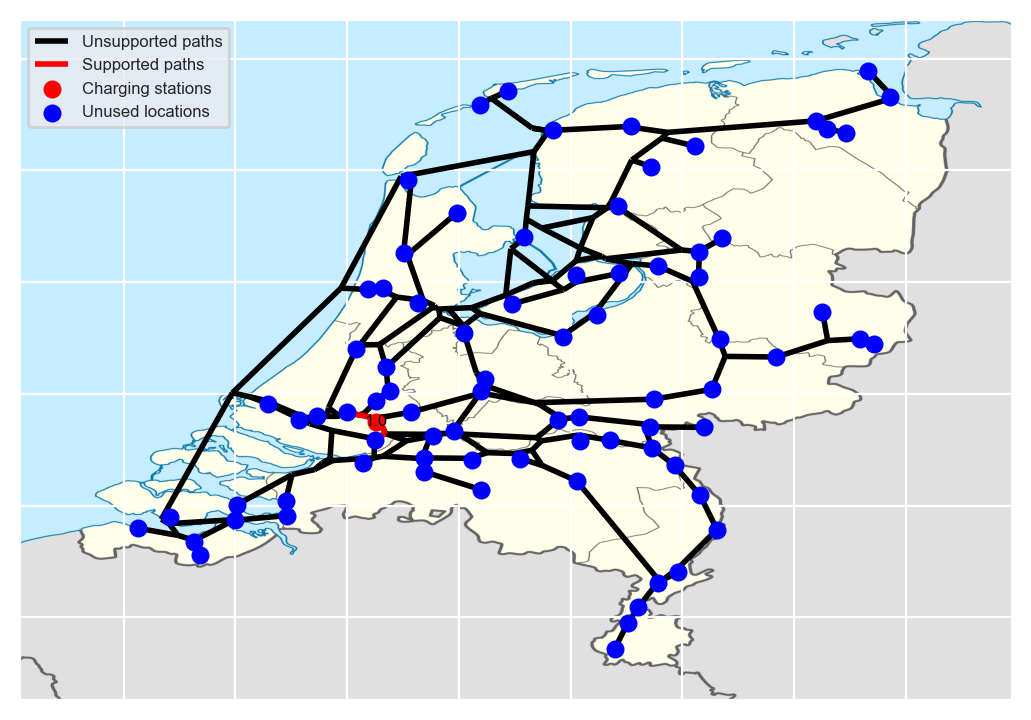

In [65]:
total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities, non_zero_flows, routes_supported, paths, G, df_abm, df_random_out, max_flow = flow_refueling_location_model(60000, 1, 10e12, 2, vis=True)

In [66]:
print("Fraction captured total:", round(fraction_captured_total, 2))
print("Fraction serviceable:", round(serviceable_fraction, 2))
print("Fraction serviced:", round(served_fraction, 2))

Fraction captured total: 0.0
Fraction serviceable: 0.09
Fraction serviced: 0.05


CFRLM:
MAXIMIZE
2703.5759068704283*Flow_captured_(('NLABL',_'NLRTM',_0),_('8863306',)) + 2703.5759068704283*Flow_captured_(('NLABL',_'NLRTM',_0),_('8866686',)) + 2212.1197716431*Flow_captured_(('NLAER',_'NLLEY',_0),_('8863709',)) + 2212.1197716431*Flow_captured_(('NLAER',_'NLLEY',_0),_('8864005',)) + 2026.4622197119347*Flow_captured_(('NLAER',_'NLSWI',_0),_('8864005',_'8867258')) + 2958.486641160946*Flow_captured_(('NLALK',_'NLIJM',_0),_('8861625',_'8862497')) + 1421.2166782652046*Flow_captured_(('NLALM',_'NLHGL',_0),_('8864153',)) + 1421.2166782652046*Flow_captured_(('NLALM',_'NLHGL',_0),_('8866512',)) + 15624.956869527026*Flow_captured_(('NLAMS',_'NLAER',_0),_('8866429',_'8864005')) + 21.60326583221266*Flow_captured_(('NLAMS',_'NLBOT',_1),_('8863206',_'8866564',_'8866429')) + 21.60326583221266*Flow_captured_(('NLAMS',_'NLBOT',_1),_('8863475',_'8866564',_'8866429')) + 67.67696184470229*Flow_captured_(('NLAMS',_'NLBOT',_2),_('8863206',_'8863360',_'8866429')) + 67.67696184470229*Flow_ca

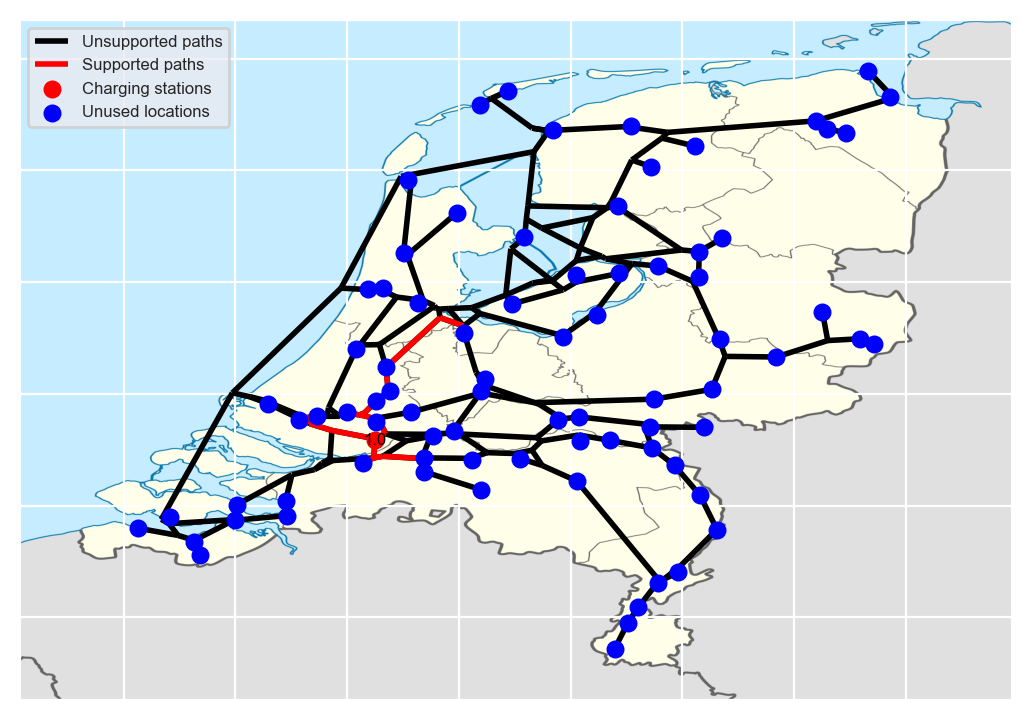

In [67]:
total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities, non_zero_flows, routes_supported, paths, G, df_abm, df_random_out, max_flow = flow_refueling_location_model(90000, 1, 10e12, 2, vis=True)

In [68]:
print("Fraction captured total:", round(fraction_captured_total, 2))
print("Fraction serviceable:", round(serviceable_fraction, 2))
print("Fraction serviced:", round(served_fraction, 2))

Fraction captured total: 0.02
Fraction serviceable: 0.24
Fraction serviced: 0.1


CFRLM:
MAXIMIZE
2703.5759068704283*Flow_captured_(('NLABL',_'NLRTM',_0),_('8863306',)) + 2703.5759068704283*Flow_captured_(('NLABL',_'NLRTM',_0),_('8866686',)) + 2212.1197716431006*Flow_captured_(('NLAER',_'NLLEY',_0),_('8863709',)) + 2212.1197716431006*Flow_captured_(('NLAER',_'NLLEY',_0),_('8864005',)) + 11277.026528683966*Flow_captured_(('NLAER',_'NLNIE',_0),_('8864005',_'8863360')) + 11277.026528683966*Flow_captured_(('NLAER',_'NLNIE',_0),_('8867538',_'8864005')) + 29584.428391712176*Flow_captured_(('NLAER',_'NLRTM',_0),_('8864005',_'8863360')) + 29584.428391712176*Flow_captured_(('NLAER',_'NLRTM',_0),_('8867538',_'8864005')) + 2026.4622197119354*Flow_captured_(('NLAER',_'NLSWI',_0),_('8864005',)) + 2026.4622197119354*Flow_captured_(('NLAER',_'NLSWI',_0),_('8867258',)) + 2958.486641160946*Flow_captured_(('NLALK',_'NLIJM',_0),_('8861625',_'8862497')) + 1421.2166782652046*Flow_captured_(('NLALM',_'NLHGL',_0),_('8864153',)) + 1421.2166782652046*Flow_captured_(('NLALM',_'NLHGL',_0),_('

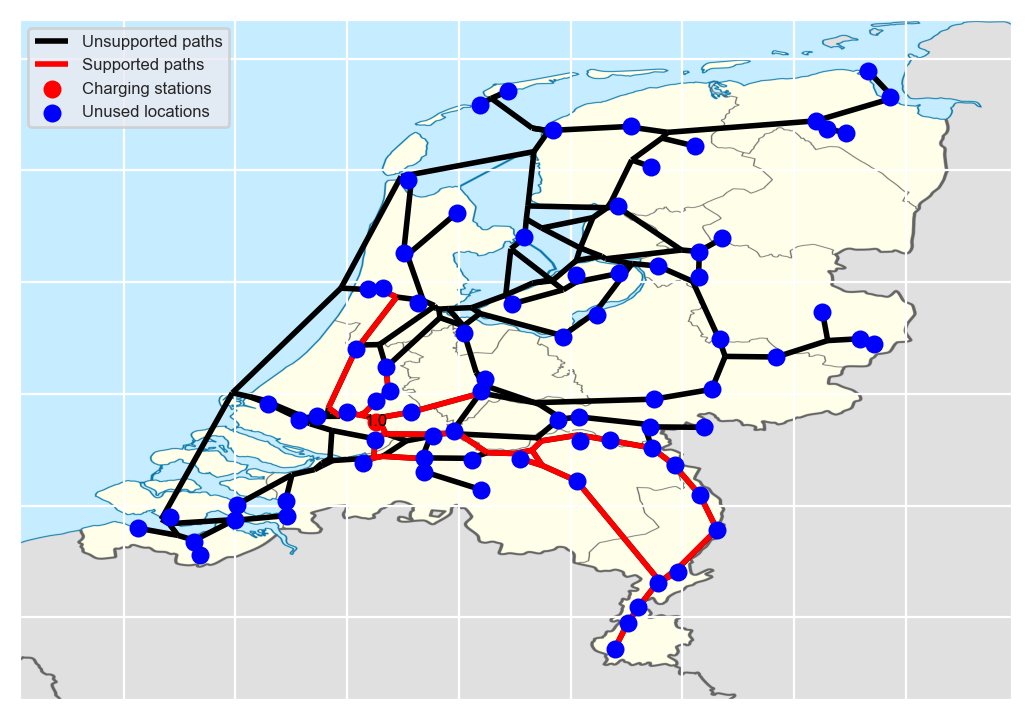

In [69]:
total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities, non_zero_flows, routes_supported, paths, G, df_abm, df_random_out, max_flow = flow_refueling_location_model(120000, 1, 10e12, 2, vis=True)

In [70]:
print("Fraction captured total:", round(fraction_captured_total, 2))
print("Fraction serviceable:", round(serviceable_fraction, 2))
print("Fraction serviced:", round(served_fraction, 2))

Fraction captured total: 0.03
Fraction serviceable: 0.53
Fraction serviced: 0.06


CFRLM:
MAXIMIZE
2703.5759068704288*Flow_captured_(('NLABL',_'NLRTM',_0),_('8863306',)) + 2703.5759068704288*Flow_captured_(('NLABL',_'NLRTM',_0),_('8866686',)) + 2212.1197716431*Flow_captured_(('NLAER',_'NLLEY',_0),_('8863709',)) + 2212.1197716431*Flow_captured_(('NLAER',_'NLLEY',_0),_('8864005',)) + 11277.026528683968*Flow_captured_(('NLAER',_'NLNIE',_0),_('8864005',_'8863360')) + 11277.026528683968*Flow_captured_(('NLAER',_'NLNIE',_0),_('8867538',_'8864005')) + 29584.428391712176*Flow_captured_(('NLAER',_'NLRTM',_0),_('8863306',_'8864005')) + 29584.428391712176*Flow_captured_(('NLAER',_'NLRTM',_0),_('8864005',_'8863360')) + 29584.428391712176*Flow_captured_(('NLAER',_'NLRTM',_0),_('8867538',_'8864005')) + 2026.4622197119354*Flow_captured_(('NLAER',_'NLSWI',_0),_('8864005',)) + 2026.4622197119354*Flow_captured_(('NLAER',_'NLSWI',_0),_('8867258',)) + 2958.4866411609455*Flow_captured_(('NLALK',_'NLIJM',_0),_('8861625',)) + 2958.4866411609455*Flow_captured_(('NLALK',_'NLIJM',_0),_('88624

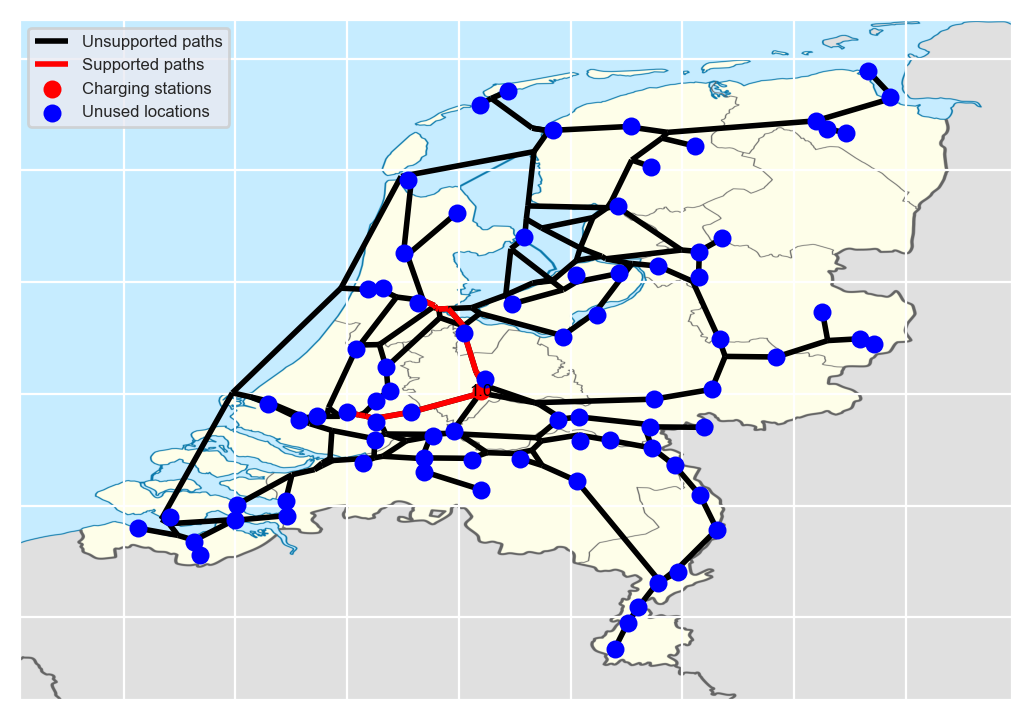

In [71]:
total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities, non_zero_flows, routes_supported, paths, G, df_abm, df_random_out, max_flow = flow_refueling_location_model(150000, 1, 10e12, 2, vis=True)

In [72]:
print("Fraction captured total:", round(fraction_captured_total, 2))
print("Fraction serviceable:", round(serviceable_fraction, 2))
print("Fraction serviced:", round(served_fraction, 2))

Fraction captured total: 0.09
Fraction serviceable: 0.75
Fraction serviced: 0.12


## Scenario that covers large part of the network

CFRLM:
MAXIMIZE
2703.5759068704288*Flow_captured_(('NLABL',_'NLRTM',_0),_('8863306',)) + 2703.5759068704288*Flow_captured_(('NLABL',_'NLRTM',_0),_('8866686',)) + 2212.1197716431*Flow_captured_(('NLAER',_'NLLEY',_0),_('8863709',)) + 2212.1197716431*Flow_captured_(('NLAER',_'NLLEY',_0),_('8864005',)) + 11277.026528683964*Flow_captured_(('NLAER',_'NLNIE',_0),_('8863360',)) + 11277.026528683964*Flow_captured_(('NLAER',_'NLNIE',_0),_('8864005',)) + 11277.026528683964*Flow_captured_(('NLAER',_'NLNIE',_0),_('8867538',)) + 29584.428391712187*Flow_captured_(('NLAER',_'NLRTM',_0),_('8863306',)) + 29584.428391712187*Flow_captured_(('NLAER',_'NLRTM',_0),_('8863360',)) + 29584.428391712187*Flow_captured_(('NLAER',_'NLRTM',_0),_('8864005',)) + 29584.428391712187*Flow_captured_(('NLAER',_'NLRTM',_0),_('8867538',)) + 2026.462219711935*Flow_captured_(('NLAER',_'NLSWI',_0),_('8864005',)) + 2026.462219711935*Flow_captured_(('NLAER',_'NLSWI',_0),_('8867258',)) + 2958.4866411609446*Flow_captured_(('NLALK',

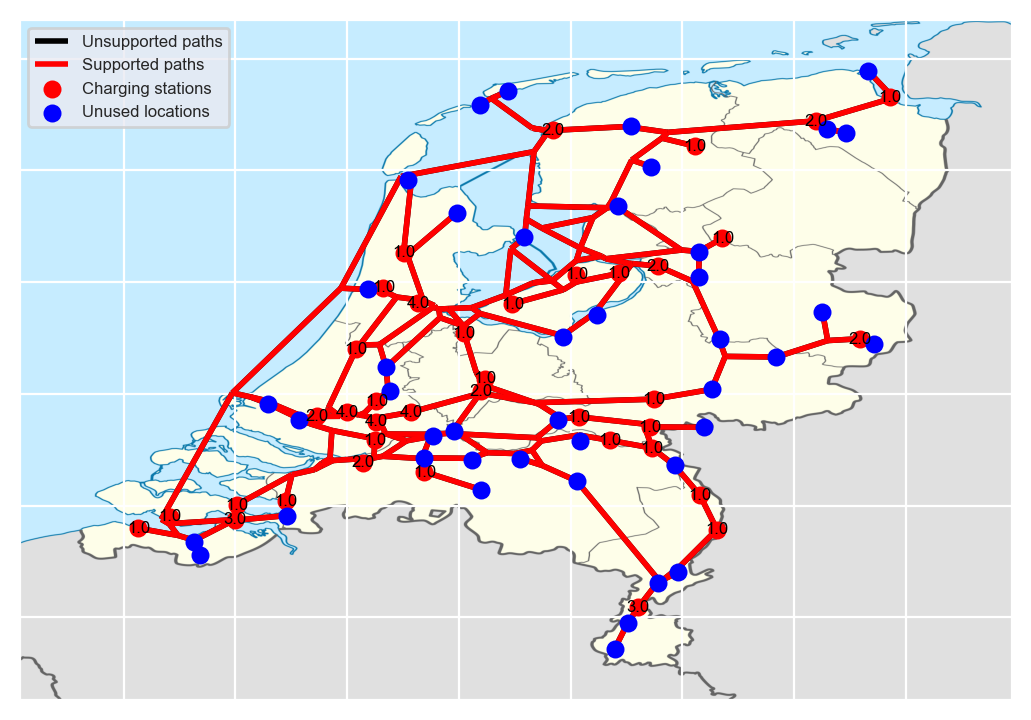

In [3]:
total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities4, non_zero_flows, routes_supported, paths, G, df_abm, df_random_out, max_flow = flow_refueling_location_model(1000000, 100, 2500, 4, vis=True, additional_nodes=0)

In [5]:
print("Fraction captured total:", round(fraction_captured_total, 2))
print("Fraction serviceable:", round(serviceable_fraction, 2))
print("Fraction serviced:", round(served_fraction, 2))
print("Expected occupation:", round(max_flow / (61 * 2500), 2))
print(sum(optimal_facilities4.values()))

Fraction captured total: 1.0
Fraction serviceable: 1.0
Fraction serviced: 1.0
Expected occupation: 19.29
61.0


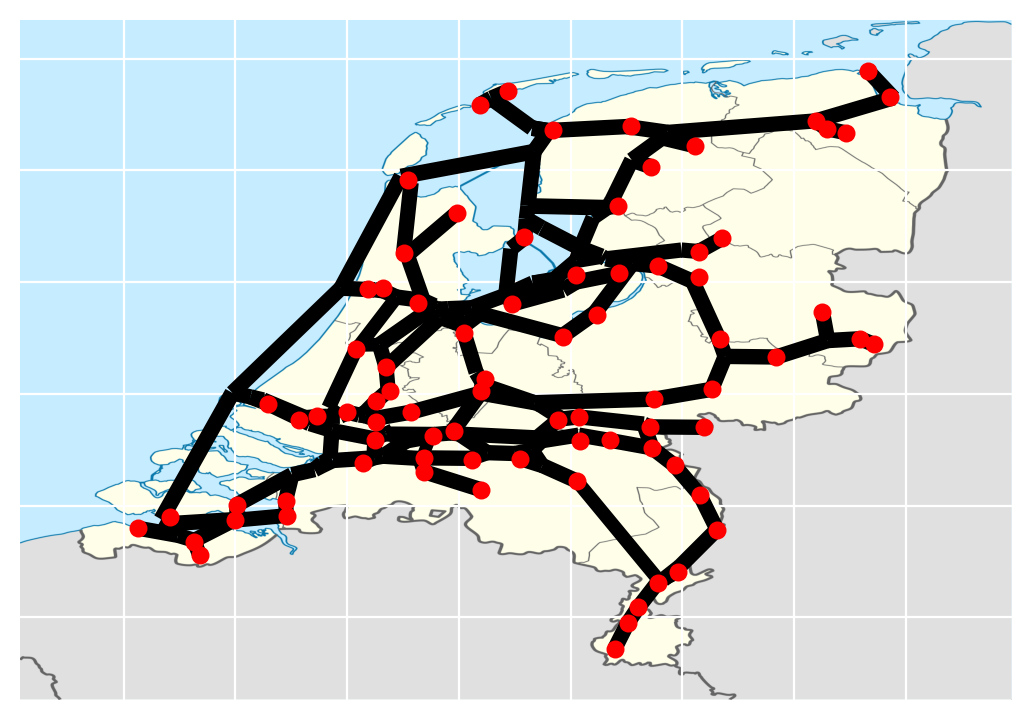

In [24]:
captured_flows = {i: sum(non_zero_flows[i]['flows']) for i in non_zero_flows.keys()}
captured_flows = {i: j * flows[i] for i, j in captured_flows.items()}
widths6 = plot_context(G, captured_flows, 'captured_flow_150000_100', 5)